In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
import umap.plot

In [3]:
input_path = r'/Volumes/Behaviour/Tailored 3sec 2P Trials'
output_path = r'/Volumes/Behaviour/Tailored 3sec 2P Trials/Random Forest Classifier'
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']
mice = ['2P05', '2P06', '2P07', '2P08', '2P09', '2P10', '2P11']
sessions = [session for session in os.listdir(input_path) if session.endswith('.csv')]
len(sessions)

48

In [4]:
session_names = []
accuracies = []

for session in [sessions[16]]:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Add 'category' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick'),
    (cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['noxious', 'innocuous', 'control']

    cells['category'] = np.select(conditions, values)
    
    # Add 'binary' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick')|(cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['stimulation', 'control']

    cells['binary'] = np.select(conditions, values)
    
    # Try a SVM on single session
    category = np.array(cells['category'])
    binary = np.array(cells['binary'])
    modality = np.array(cells['modality'])
    data = cells.drop(['identifier','modality', 'category','binary'], axis=1)
    data = np.array(data)
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, modality, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality', metrics.accuracy_score(y_test, y_pred)])
    
#     # CATEGORY
#     # Split dataset into training set and test set
#     X_train, X_test, y_train, y_test = train_test_split(data, category, test_size=0.3,random_state=109) # 70% training and 30% test

#     clf = RandomForestClassifier(n_estimators=100)

#     #Train the model using the training sets
#     clf.fit(X_train, y_train)

#     #Predict the response for test dataset
#     y_pred = clf.predict(X_test)

#     print("Accuracy category:",metrics.accuracy_score(y_test, y_pred))
#     accuracies.append([ses_name, 'category', metrics.accuracy_score(y_test, y_pred)])   

#     # BINARY
#     # Split dataset into training set and test set
#     X_train, X_test, y_train, y_test = train_test_split(data, binary, test_size=0.3,random_state=109) # 70% training and 30% test

#     clf = RandomForestClassifier(n_estimators=100)

#     #Train the model using the training sets
#     clf.fit(X_train, y_train)

#     #Predict the response for test dataset
#     y_pred = clf.predict(X_test)

#     print("Accuracy binary:",metrics.accuracy_score(y_test, y_pred))
#     accuracies.append([ses_name, 'binary', metrics.accuracy_score(y_test, y_pred)])
    
#     feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
#     feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
#     feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'.csv'))
    
# cols = ['session', 'classification', 'accuracy']
# rfc_accuracy = pd.DataFrame(accuracies, columns=cols)
# rfc_accuracy.to_csv(os.path.join(output_path, 'rfc_accuracies.csv'))

processing:  dF_F0_SHORT_2P07_Ses05.csv
2P07_Ses05
Accuracy modality: 0.9854014598540146


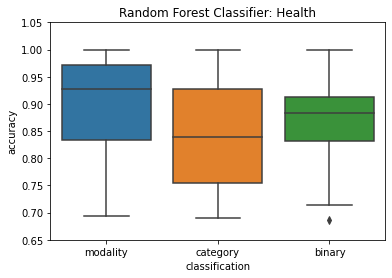

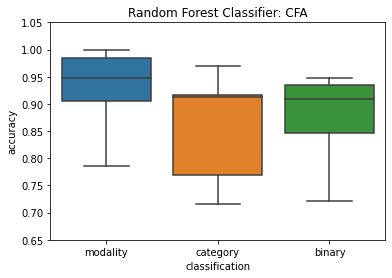

In [10]:
import seaborn as sns

health = rfc_accuracy[rfc_accuracy['session'].str.contains('Ses')]
cfa = rfc_accuracy[rfc_accuracy['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Random Forest Classifier: Health')
plt.ylim([0.65,1.05])
plt.savefig(os.path.join(output_path, 'rfc_health.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Random Forest Classifier: CFA')
plt.ylim([0.65,1.05])
plt.savefig(os.path.join(output_path, 'rfc_cfa.png'),bbox_inches='tight')
plt.show()

In [11]:
# Shuffle trial order of X_test
session_names = []
accuracies = []

for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Add 'category' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick'),
    (cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['noxious', 'innocuous', 'control']

    cells['category'] = np.select(conditions, values)
    
    # Add 'binary' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick')|(cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['stimulation', 'control']

    cells['binary'] = np.select(conditions, values)
    
    # Try a RFC on single session
    category = np.array(cells['category'])
    binary = np.array(cells['binary'])
    modality = np.array(cells['modality'])
    data = cells.drop(['identifier','modality', 'category','binary'], axis=1)
    data = np.array(data)
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, modality, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    # shuffle order of rows in test set
    df = pd.DataFrame(X_test, columns = cell_ids[:-1])
    df['modality'] = y_test
    df = df.sample(frac = 1)
    y_test = np.array(df['modality'])
    X_test = np.array(df.drop(['modality'], axis=1))
    
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality', metrics.accuracy_score(y_test, y_pred)])
    
    # CATEGORY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, category, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    # shuffle order of rows in test set
    df = pd.DataFrame(X_test, columns = cell_ids[:-1])
    df['category'] = y_test
    df = df.sample(frac = 1)
    y_test = np.array(df['category'])
    X_test = np.array(df.drop(['category'], axis=1))
    
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy category:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'category', metrics.accuracy_score(y_test, y_pred)])   

    # BINARY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, binary, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)
    
    # shuffle order of rows in test set
    df = pd.DataFrame(X_test, columns = cell_ids[:-1])
    df['binary'] = y_test
    df = df.sample(frac = 1)
    y_test = np.array(df['binary'])
    X_test = np.array(df.drop(['binary'], axis=1))
    
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy binary:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'binary', metrics.accuracy_score(y_test, y_pred)])
    
    feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
    feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
    feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'.csv'))
    
cols = ['session', 'classification', 'accuracy']
rfc_accuracy_shuffle_trials = pd.DataFrame(accuracies, columns=cols)
rfc_accuracy_shuffle_trials.to_csv(os.path.join(output_path, 'rfc_accuracies_shuffle_trials.csv'))

processing:  dF_F0_SHORT_2P06_Ses01.csv
2P06_Ses01
Accuracy modality: 1.0
Accuracy category: 1.0
Accuracy binary: 0.9854014598540146
processing:  dF_F0_SHORT_2P06_Ses02.csv
2P06_Ses02
Accuracy modality: 1.0
Accuracy category: 1.0
Accuracy binary: 1.0
processing:  dF_F0_SHORT_2P06_Ses03.csv
2P06_Ses03
Accuracy modality: 1.0
Accuracy category: 1.0
Accuracy binary: 1.0
processing:  dF_F0_SHORT_2P05_Ses04.csv
2P05_Ses04
Accuracy modality: 0.9124087591240876
Accuracy category: 0.8248175182481752
Accuracy binary: 0.9124087591240876
processing:  dF_F0_SHORT_2P06_Ses04.csv
2P06_Ses04
Accuracy modality: 1.0
Accuracy category: 0.9664429530201343
Accuracy binary: 0.9731543624161074
processing:  dF_F0_SHORT_2P06_Ses05.csv
2P06_Ses05
Accuracy modality: 0.9927007299270073
Accuracy category: 0.9416058394160584
Accuracy binary: 0.948905109489051
processing:  dF_F0_SHORT_2P05_Ses06.csv
2P05_Ses06
Accuracy modality: 0.8248175182481752
Accuracy category: 0.7518248175182481
Accuracy binary: 0.766423357664

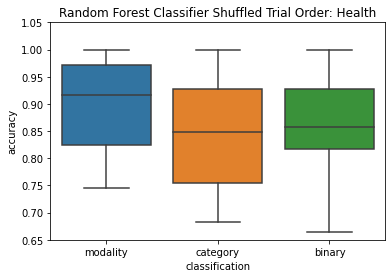

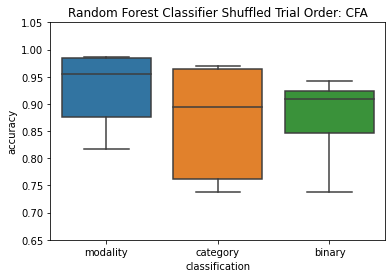

In [12]:
import seaborn as sns

health = rfc_accuracy_shuffle_trials[rfc_accuracy_shuffle_trials['session'].str.contains('Ses')]
cfa = rfc_accuracy_shuffle_trials[rfc_accuracy_shuffle_trials['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Random Forest Classifier Shuffled Trial Order: Health')
plt.ylim([0.65,1.05])
plt.savefig(os.path.join(output_path, 'rfc_shuffle_order_health.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Random Forest Classifier Shuffled Trial Order: CFA')
plt.ylim([0.65,1.05])
plt.savefig(os.path.join(output_path, 'rfc_shuffle_order_cfa.png'),bbox_inches='tight')
plt.show()

In [13]:
# Scramble target labels of train set (y_train)
session_names = []
accuracies = []

for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Add 'category' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick'),
    (cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['noxious', 'innocuous', 'control']

    cells['category'] = np.select(conditions, values)
    
    # Add 'binary' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick')|(cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['stimulation', 'control']

    cells['binary'] = np.select(conditions, values)
    
    # Try a RFC on single session
    category = np.array(cells['category'])
    binary = np.array(cells['binary'])
    modality = np.array(cells['modality'])
    data = cells.drop(['identifier','modality', 'category','binary'], axis=1)
    data = np.array(data)
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, modality, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)
    
    # shuffle order of training targets
    np.random.shuffle(y_train)
    
    #Train the model using the training sets
    clf.fit(X_train, y_train)
    
    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality', metrics.accuracy_score(y_test, y_pred)])
    
    # CATEGORY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, category, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    # shuffle order of training targets
    np.random.shuffle(y_train)
    
    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy category:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'category', metrics.accuracy_score(y_test, y_pred)])   

    # BINARY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, binary, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    # shuffle order of training targets
    np.random.shuffle(y_train)
    
    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy binary:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'binary', metrics.accuracy_score(y_test, y_pred)])
    
    feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
    feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
    feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'.csv'))
    
cols = ['session', 'classification', 'accuracy']
rfc_accuracy_scramble_labels = pd.DataFrame(accuracies, columns=cols)
rfc_accuracy_scramble_labels.to_csv(os.path.join(output_path, 'rfc_accuracies_shuffle_trials.csv'))

processing:  dF_F0_SHORT_2P06_Ses01.csv
2P06_Ses01
Accuracy modality: 0.10218978102189781
Accuracy category: 0.34306569343065696
Accuracy binary: 0.6131386861313869
processing:  dF_F0_SHORT_2P06_Ses02.csv
2P06_Ses02
Accuracy modality: 0.20454545454545456
Accuracy category: 0.4393939393939394
Accuracy binary: 0.5833333333333334
processing:  dF_F0_SHORT_2P06_Ses03.csv
2P06_Ses03
Accuracy modality: 0.09523809523809523
Accuracy category: 0.4444444444444444
Accuracy binary: 0.5873015873015873
processing:  dF_F0_SHORT_2P05_Ses04.csv
2P05_Ses04
Accuracy modality: 0.12408759124087591
Accuracy category: 0.40875912408759124
Accuracy binary: 0.5620437956204379
processing:  dF_F0_SHORT_2P06_Ses04.csv
2P06_Ses04
Accuracy modality: 0.10738255033557047
Accuracy category: 0.2684563758389262
Accuracy binary: 0.6174496644295302
processing:  dF_F0_SHORT_2P06_Ses05.csv
2P06_Ses05
Accuracy modality: 0.15328467153284672
Accuracy category: 0.3284671532846715
Accuracy binary: 0.5912408759124088
processing:  d

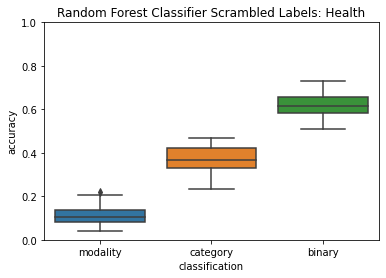

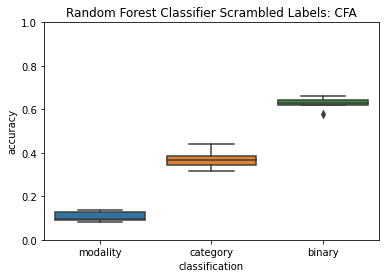

In [14]:
import seaborn as sns

health = rfc_accuracy_scramble_labels[rfc_accuracy_scramble_labels['session'].str.contains('Ses')]
cfa = rfc_accuracy_scramble_labels[rfc_accuracy_scramble_labels['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Random Forest Classifier Scrambled Labels: Health')
plt.ylim([0,1])
plt.savefig(os.path.join(output_path, 'rfc_scrambled_health.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Random Forest Classifier Scrambled Labels: CFA')
plt.ylim([0,1])
plt.savefig(os.path.join(output_path, 'rfc_scrambled_cfa.png'),bbox_inches='tight')
plt.show()

processing:  dF_F0_SHORT_2P06_Ses01.csv
2P06_Ses01
Accuracy modality: 1.0


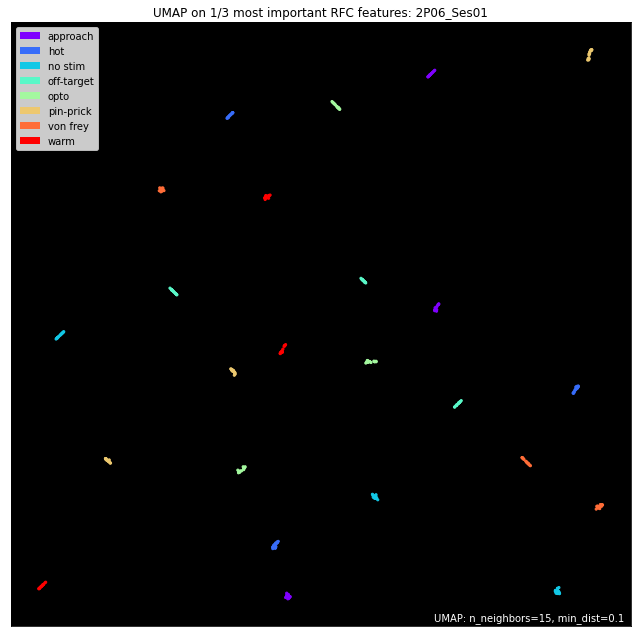

processing:  dF_F0_SHORT_2P06_Ses02.csv
2P06_Ses02
Accuracy modality: 1.0


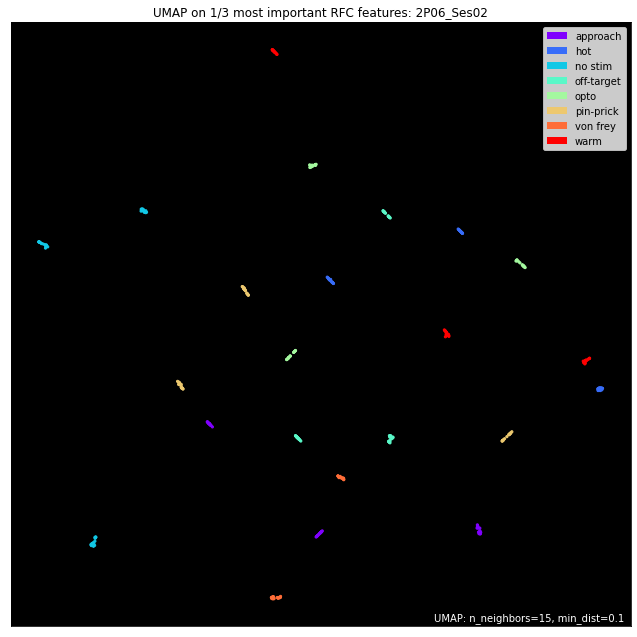

processing:  dF_F0_SHORT_2P06_Ses03.csv
2P06_Ses03
Accuracy modality: 1.0


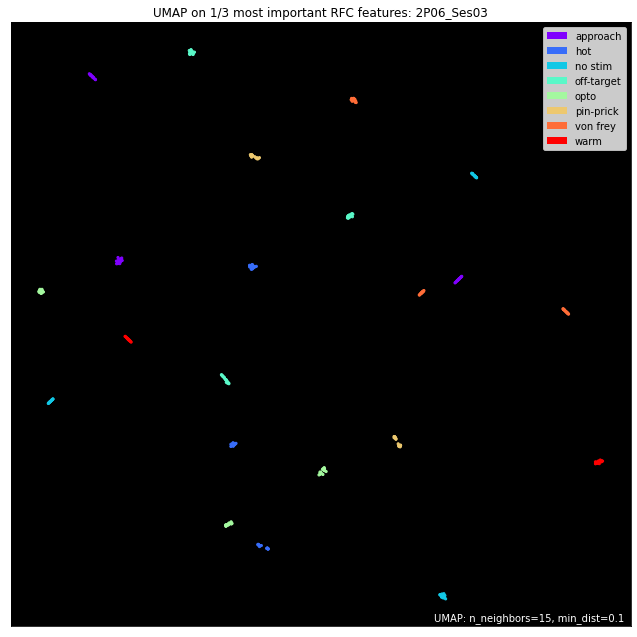

processing:  dF_F0_SHORT_2P05_Ses04.csv
2P05_Ses04
Accuracy modality: 0.9197080291970803


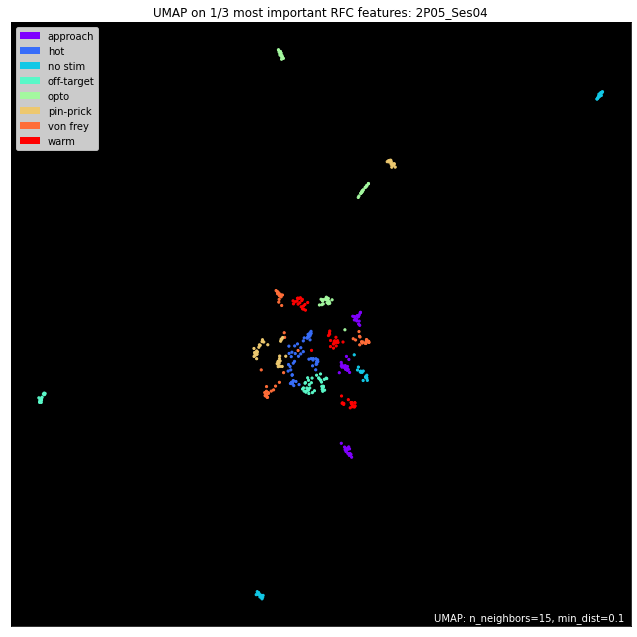

processing:  dF_F0_SHORT_2P06_Ses04.csv
2P06_Ses04
Accuracy modality: 1.0


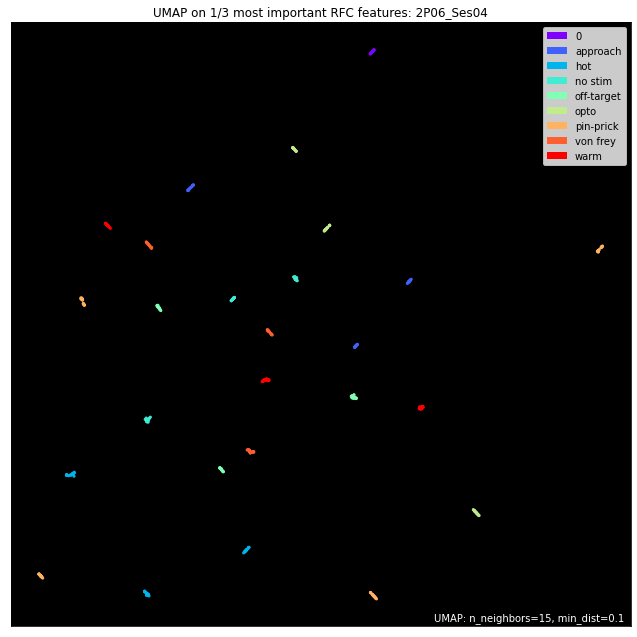

processing:  dF_F0_SHORT_2P06_Ses05.csv
2P06_Ses05
Accuracy modality: 1.0


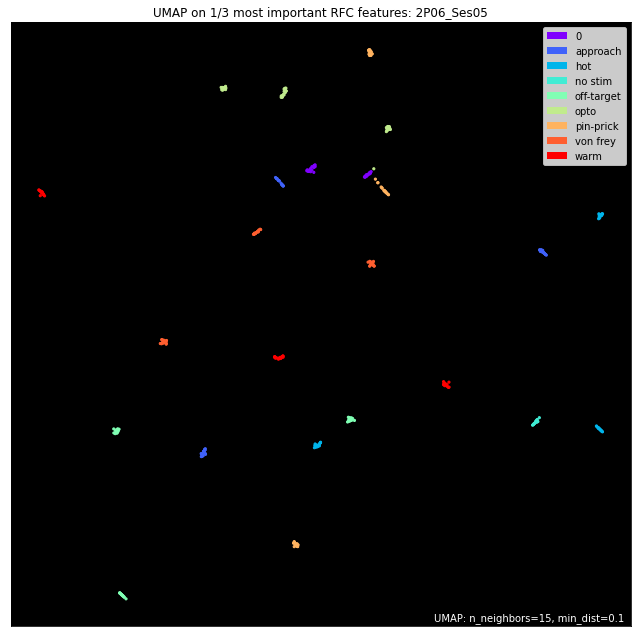

processing:  dF_F0_SHORT_2P05_Ses06.csv
2P05_Ses06
Accuracy modality: 0.8029197080291971


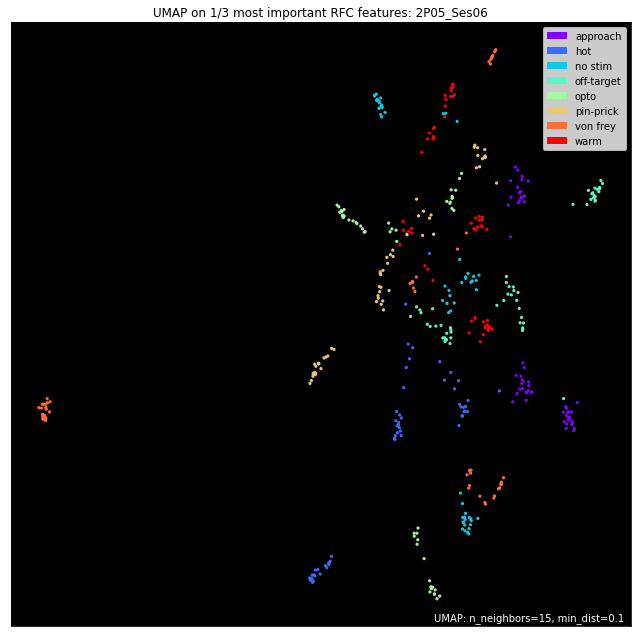

processing:  dF_F0_SHORT_2P06_Ses06.csv
2P06_Ses06
Accuracy modality: 0.9708029197080292


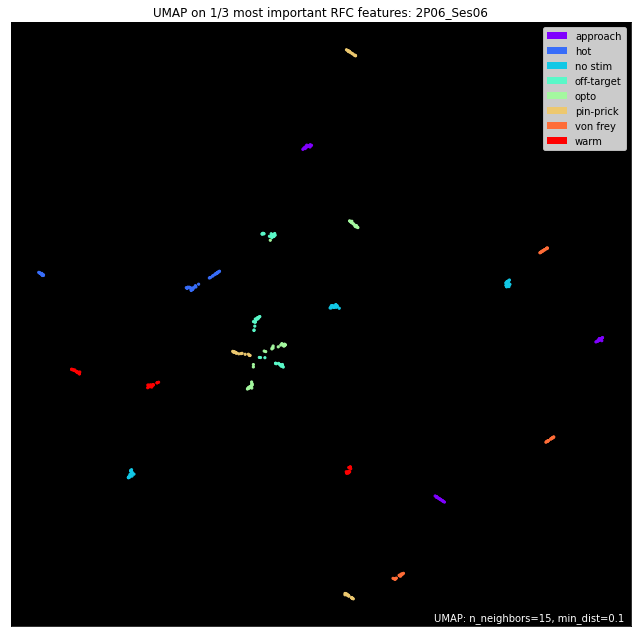

processing:  dF_F0_SHORT_2P05_Ses07.csv
2P05_Ses07
Accuracy modality: 0.8015873015873016


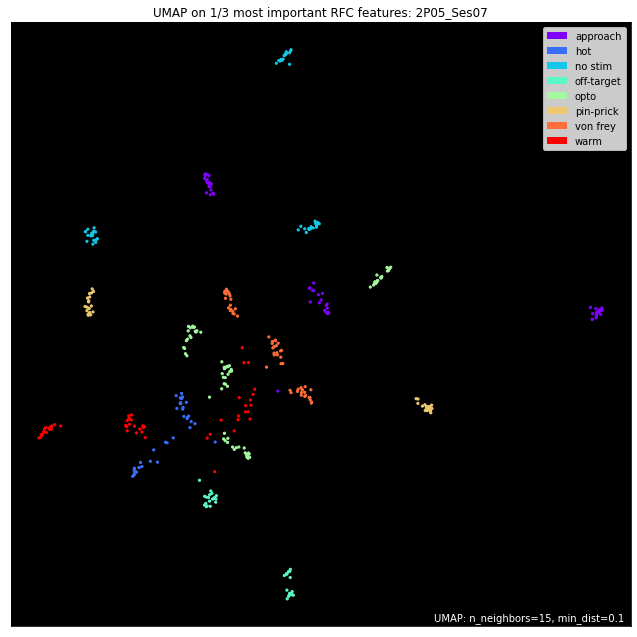

processing:  dF_F0_SHORT_2P06_Ses07.csv
2P06_Ses07
Accuracy modality: 1.0


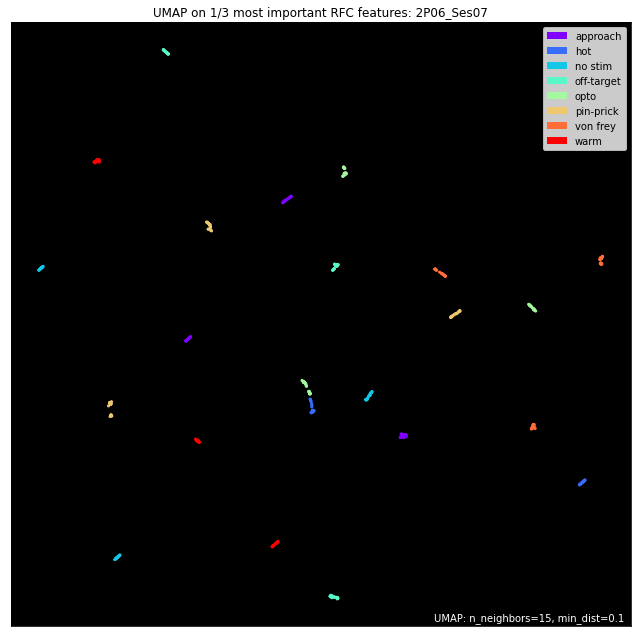

processing:  dF_F0_SHORT_2P07_Ses01.csv
2P07_Ses01
Accuracy modality: 0.7575757575757576


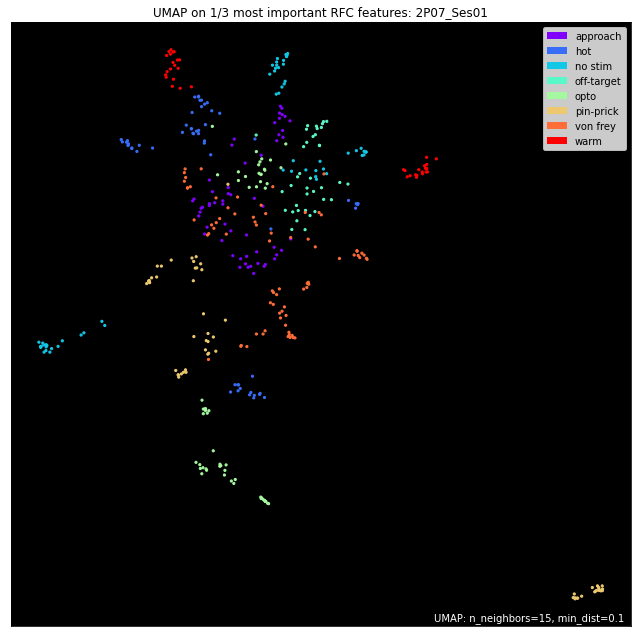

processing:  dF_F0_SHORT_2P08_Ses01.csv
2P08_Ses01
Accuracy modality: 0.7902097902097902


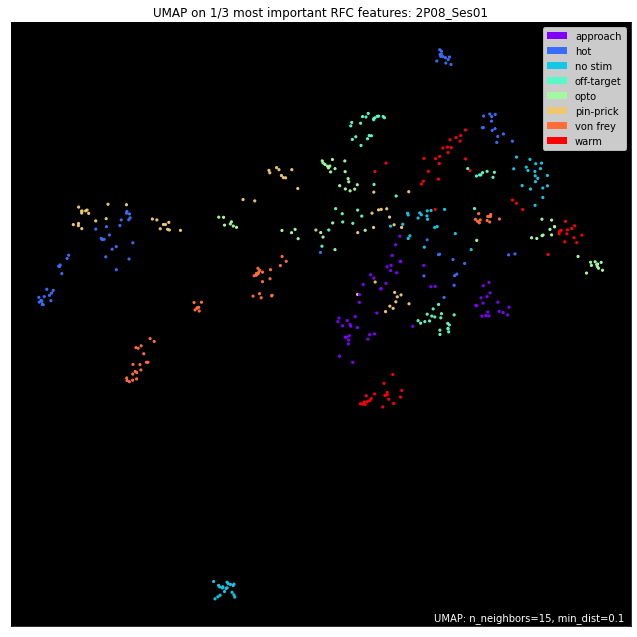

processing:  dF_F0_SHORT_2P07_Ses03.csv
2P07_Ses03
Accuracy modality: 0.9365079365079365


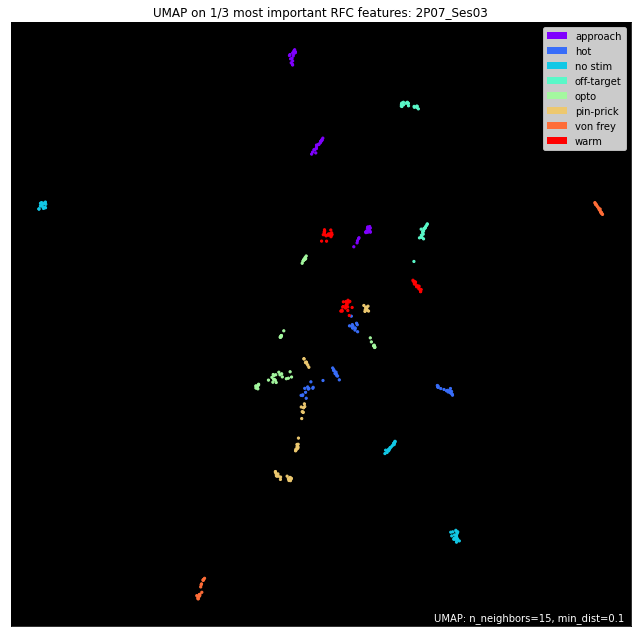

processing:  dF_F0_SHORT_2P08_Ses02.csv
2P08_Ses02
Accuracy modality: 0.9696969696969697


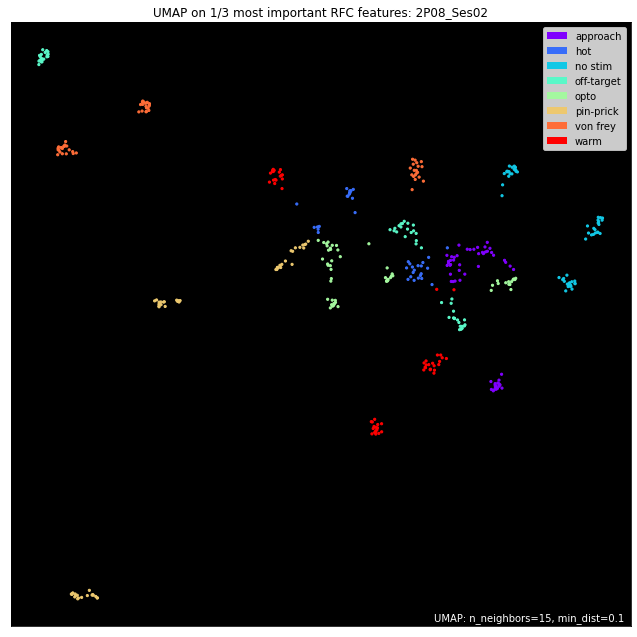

processing:  dF_F0_SHORT_2P07_Ses04.csv
2P07_Ses04
Accuracy modality: 0.8467153284671532


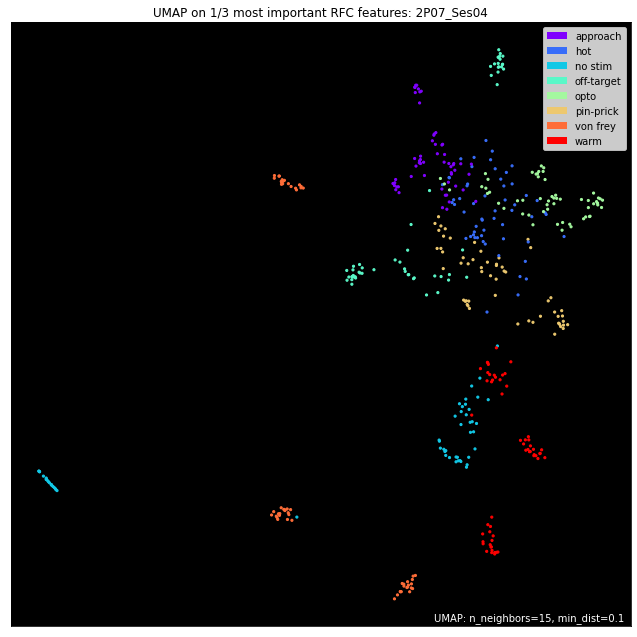

processing:  dF_F0_SHORT_2P07_Ses05.csv
2P07_Ses05
Accuracy modality: 0.9854014598540146


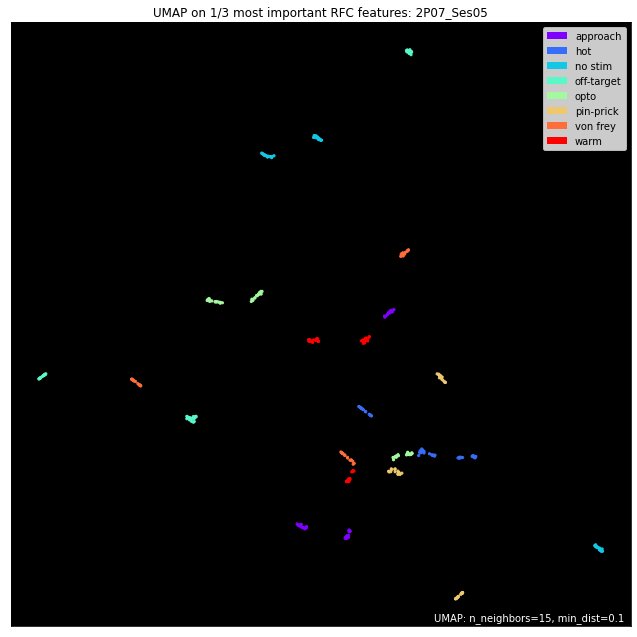

processing:  dF_F0_SHORT_2P08_Ses04.csv
2P08_Ses04
Accuracy modality: 0.8248175182481752


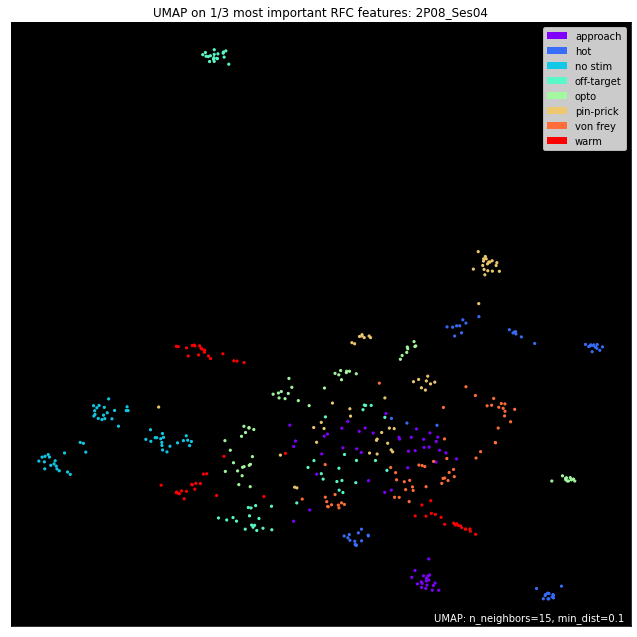

processing:  dF_F0_SHORT_2P07_Ses06.csv
2P07_Ses06
Accuracy modality: 0.9603174603174603


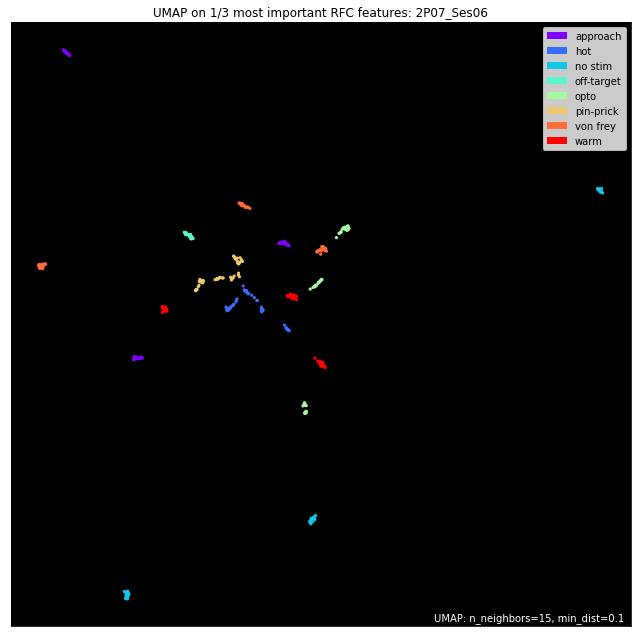

processing:  dF_F0_SHORT_2P08_Ses05.csv
2P08_Ses05
Accuracy modality: 0.9166666666666666


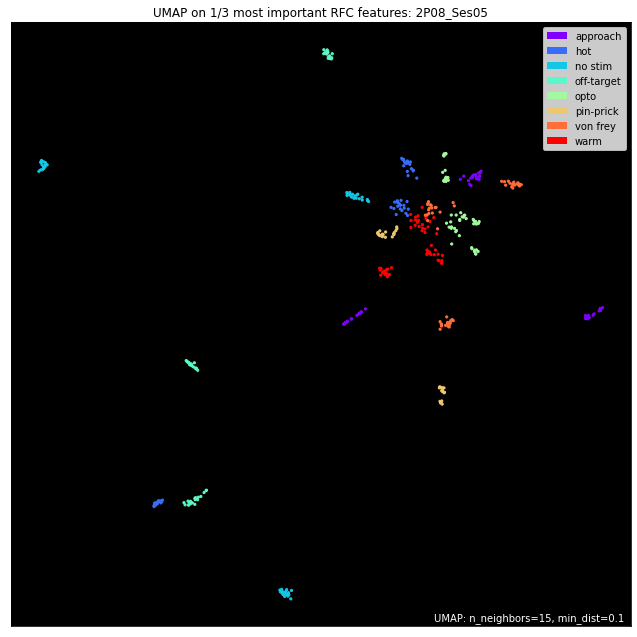

processing:  dF_F0_SHORT_2P07_Ses07.csv
2P07_Ses07
Accuracy modality: 0.9635036496350365


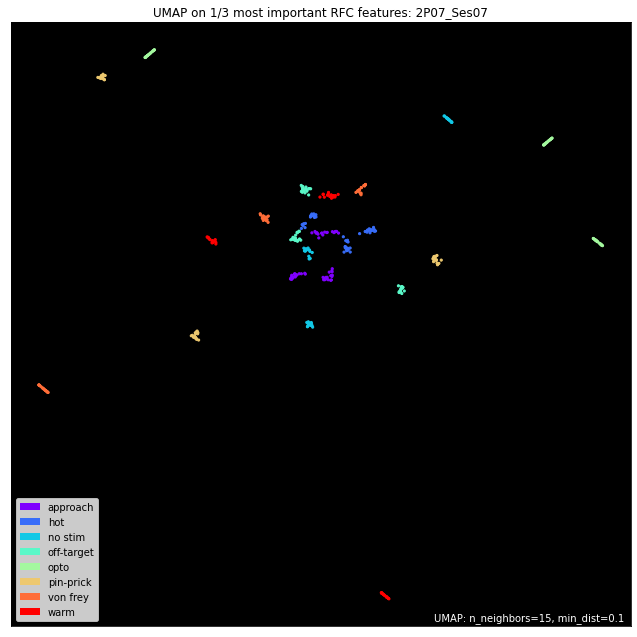

processing:  dF_F0_SHORT_2P08_Ses06.csv
2P08_Ses06
Accuracy modality: 0.8863636363636364


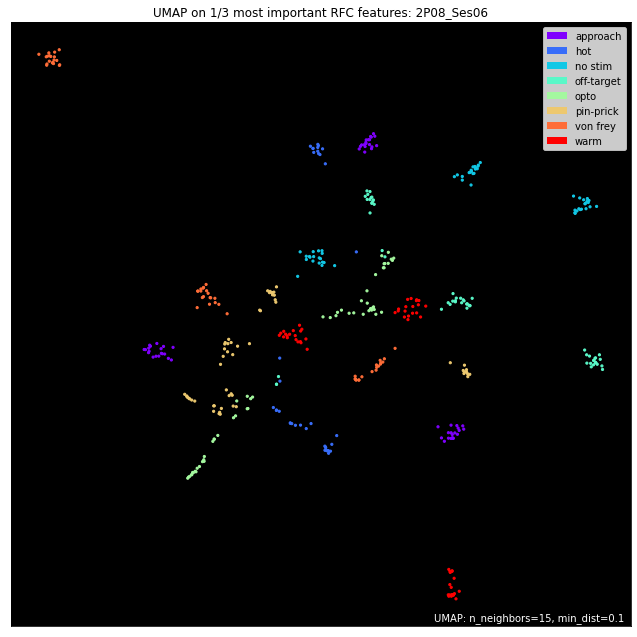

processing:  dF_F0_SHORT_2P07_CFA.csv
2P07_CFA
Accuracy modality: 0.9924242424242424


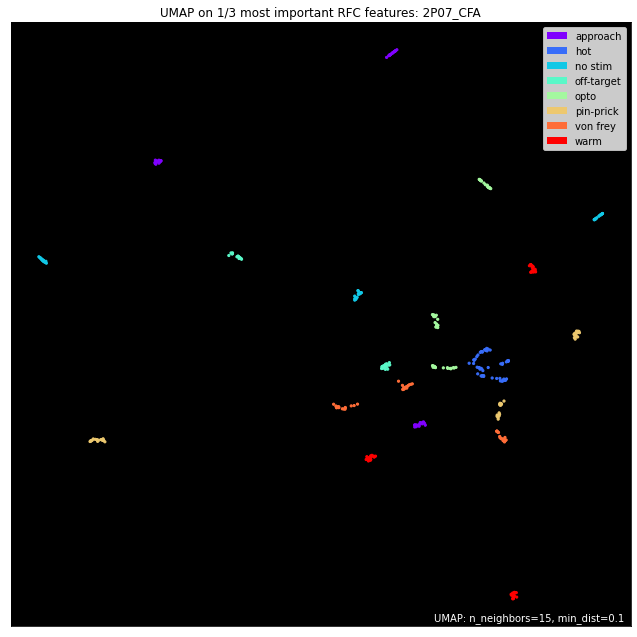

processing:  dF_F0_SHORT_2P09_Ses01.csv
2P09_Ses01
Accuracy modality: 0.7301587301587301


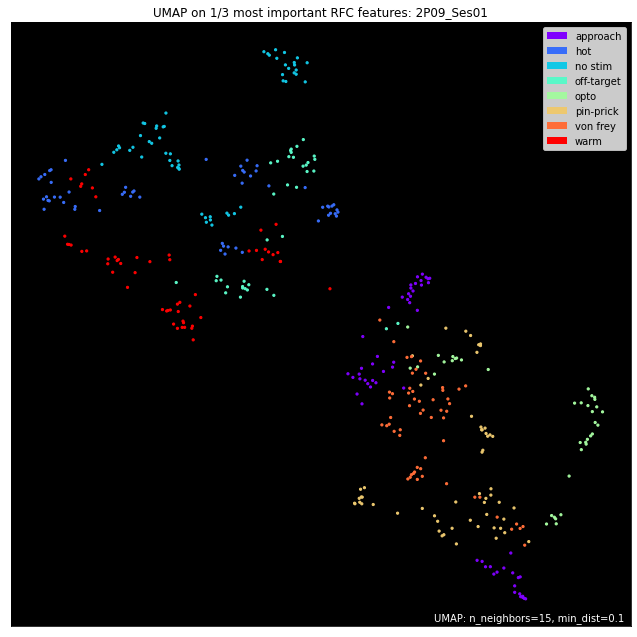

processing:  dF_F0_SHORT_2P08_CFA.csv
2P08_CFA
Accuracy modality: 0.8467153284671532


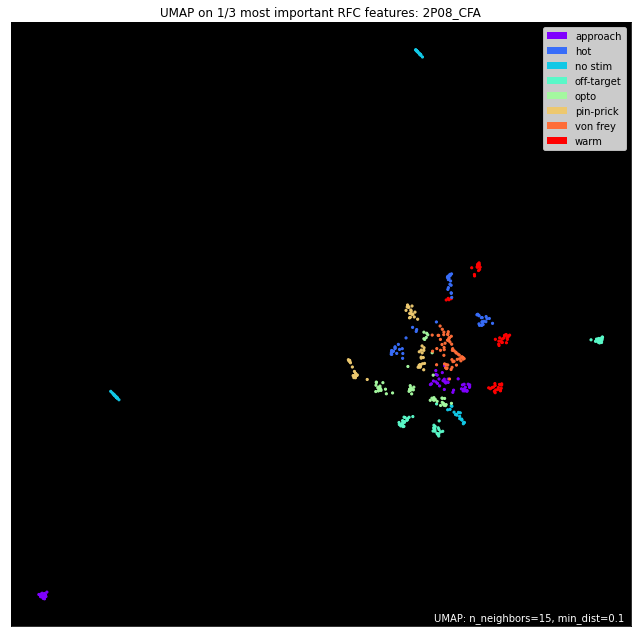

processing:  dF_F0_SHORT_2P11_Ses01.csv
2P11_Ses01
Accuracy modality: 0.8248175182481752


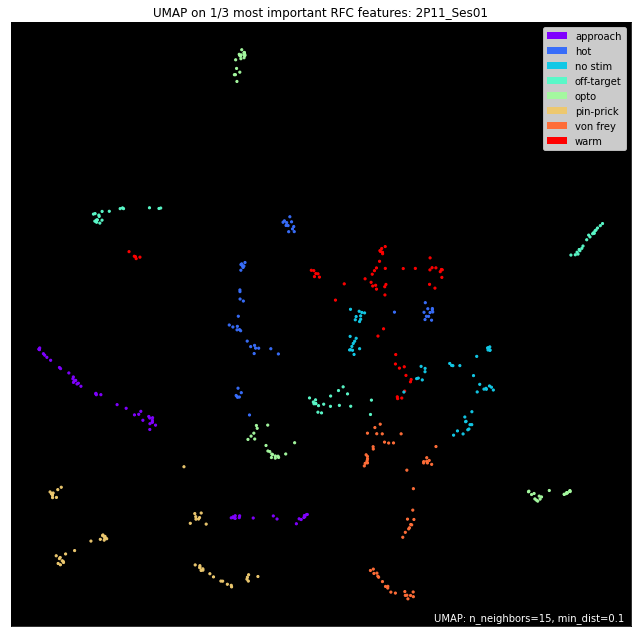

processing:  dF_F0_SHORT_2P10_Ses01.csv
2P10_Ses01
Accuracy modality: 0.9440559440559441


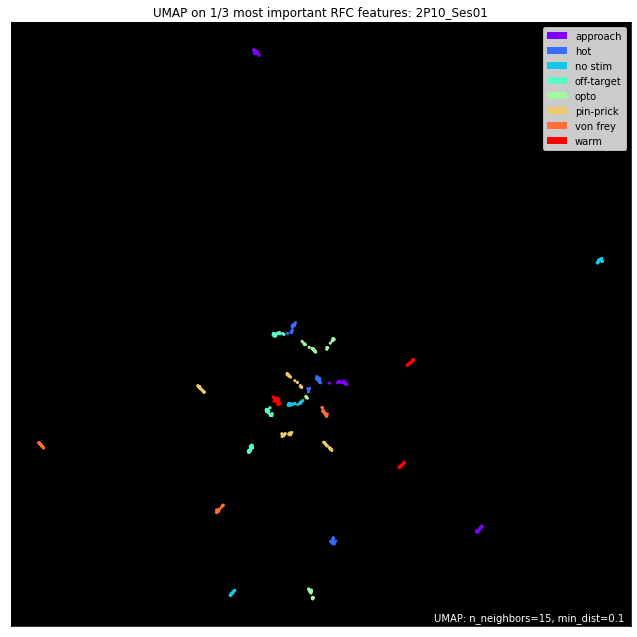

processing:  dF_F0_SHORT_2P09_Ses02.csv
2P09_Ses02
Accuracy modality: 0.8671328671328671


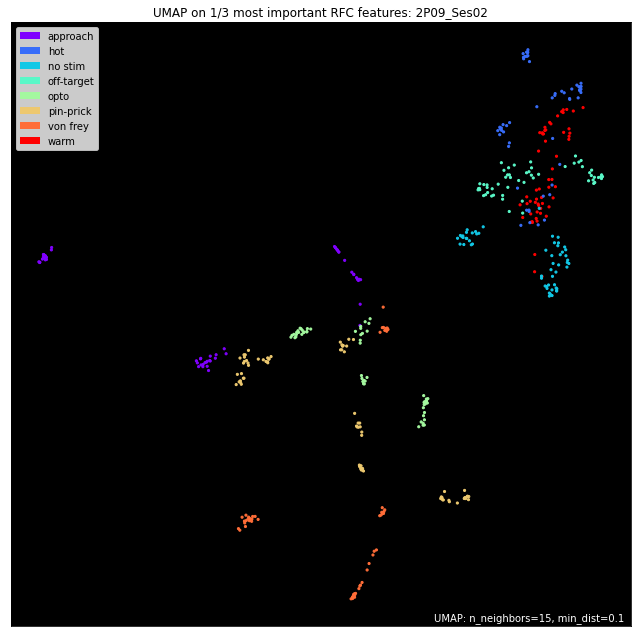

processing:  dF_F0_SHORT_2P10_Ses02.csv
2P10_Ses02
Accuracy modality: 0.8257575757575758


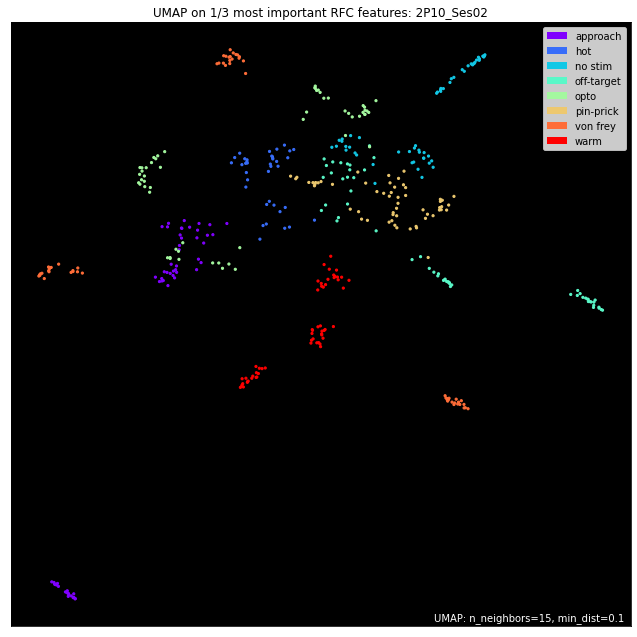

processing:  dF_F0_SHORT_2P09_Ses04.csv
2P09_Ses04
Accuracy modality: 0.7445255474452555


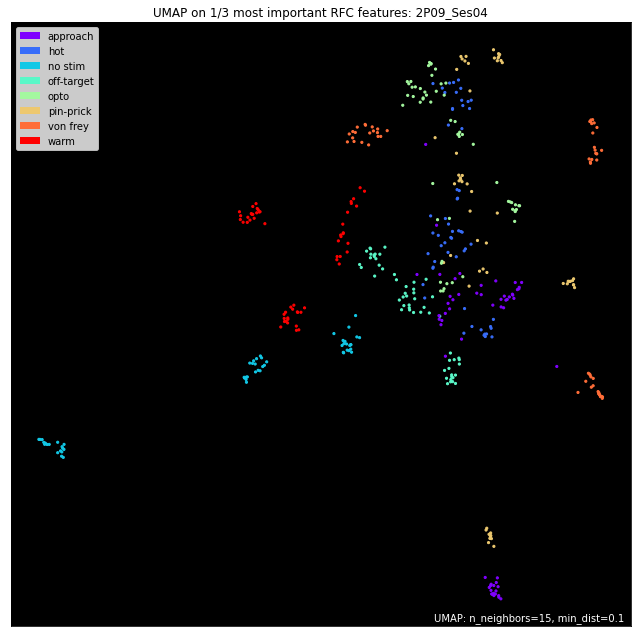

processing:  dF_F0_SHORT_2P11_Ses04.csv
2P11_Ses04
Accuracy modality: 0.948905109489051


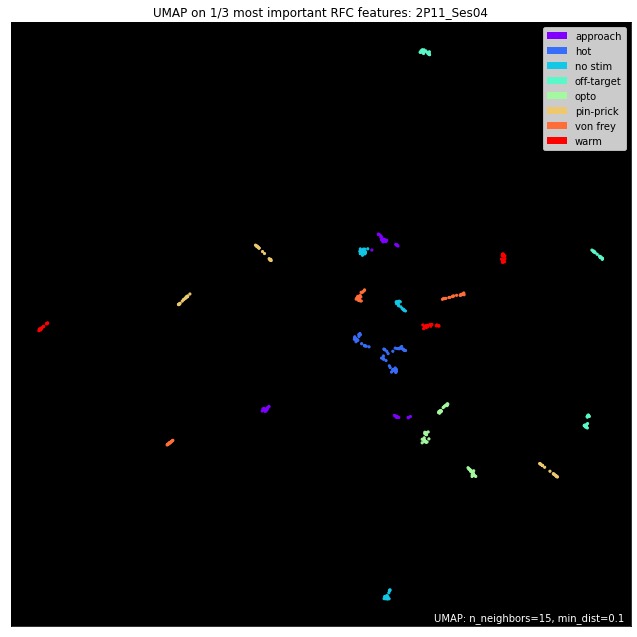

processing:  dF_F0_SHORT_2P11_Ses05.csv
2P11_Ses05
Accuracy modality: 0.9473684210526315


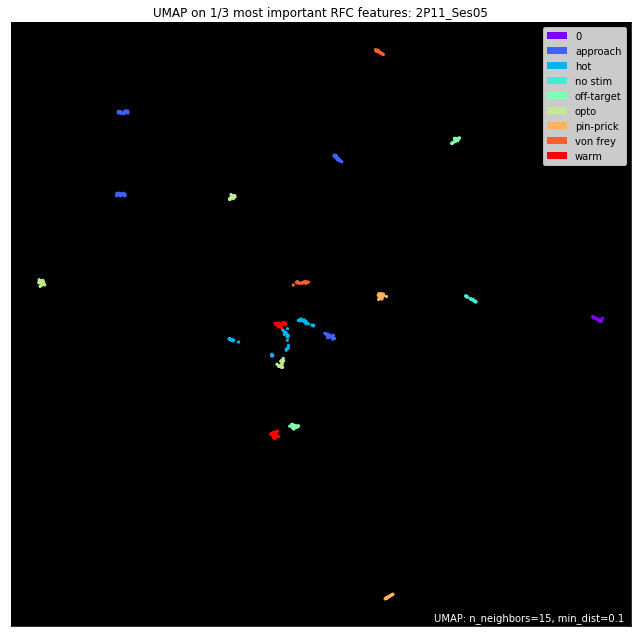

processing:  dF_F0_SHORT_2P10_CFA.csv
2P10_CFA
Accuracy modality: 1.0


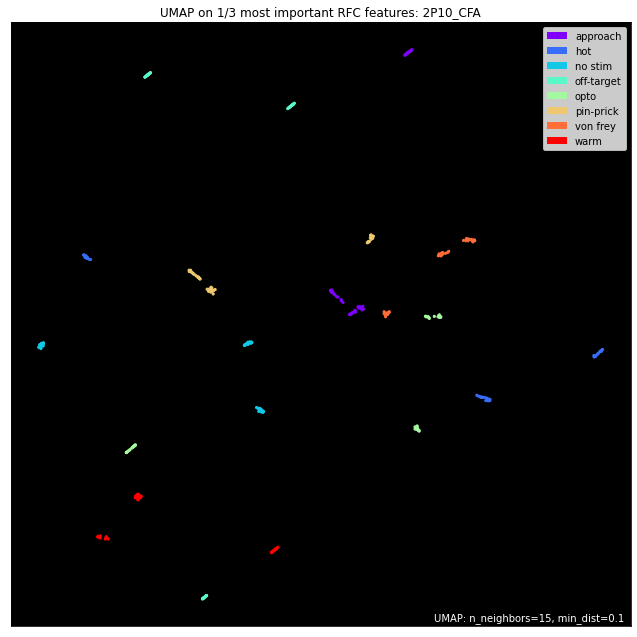

processing:  dF_F0_SHORT_2P09_CFA.csv
2P09_CFA
Accuracy modality: 0.8095238095238095


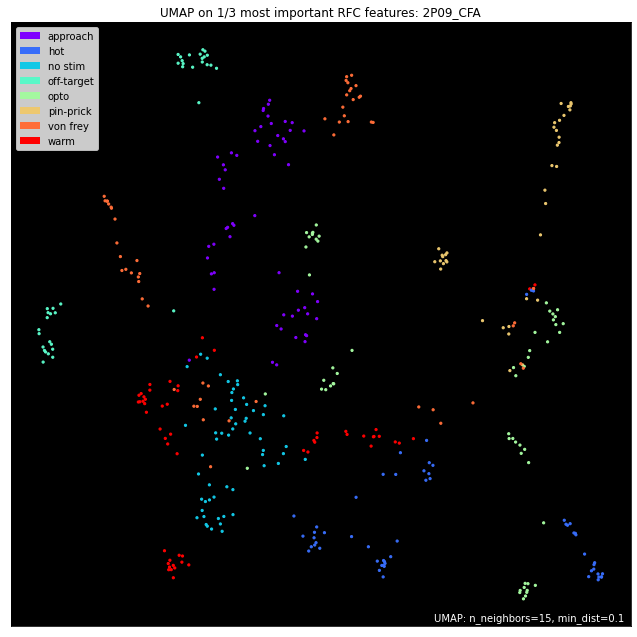

processing:  dF_F0_SHORT_2P11_Ses02.csv
2P11_Ses02
Accuracy modality: 0.9393939393939394


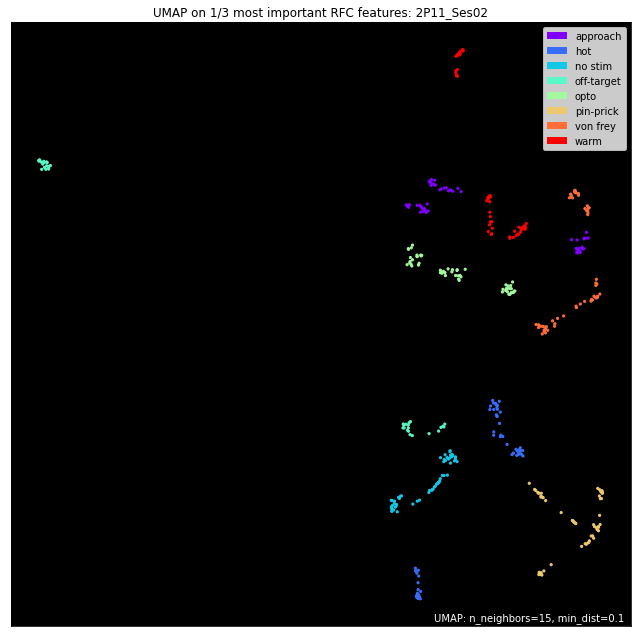

processing:  dF_F0_SHORT_2P09_Ses03.csv
2P09_Ses03
Accuracy modality: 0.8613138686131386


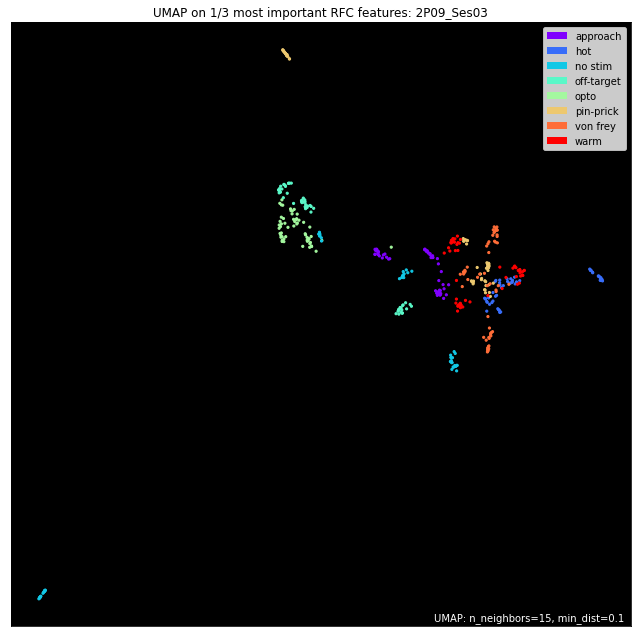

processing:  dF_F0_SHORT_2P10_Ses03.csv
2P10_Ses03
Accuracy modality: 0.8787878787878788


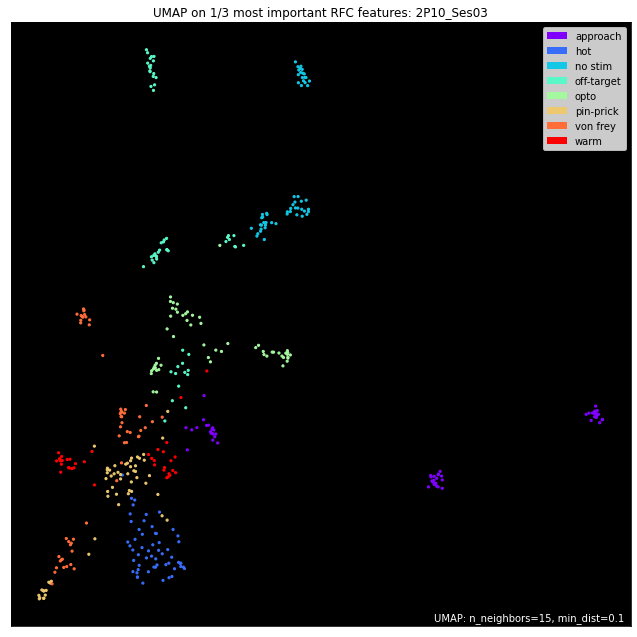

processing:  dF_F0_SHORT_2P10_Ses04.csv
2P10_Ses04
Accuracy modality: 0.8888888888888888


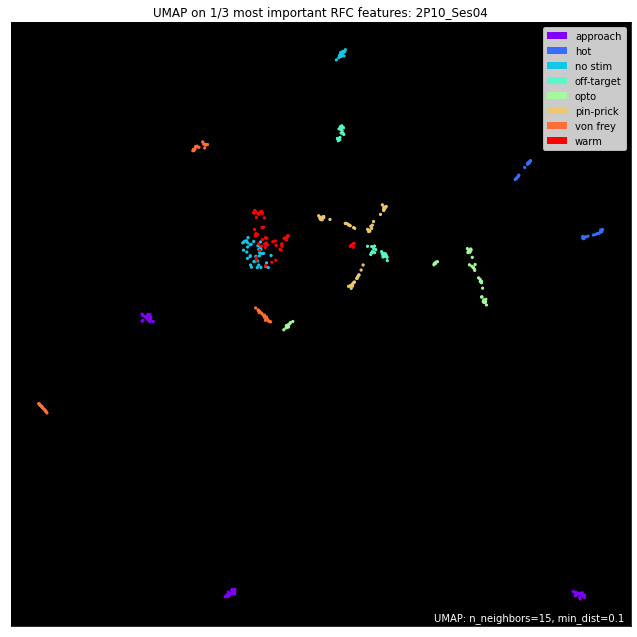

processing:  dF_F0_SHORT_2P09_Ses05.csv
2P09_Ses05
Accuracy modality: 0.8686131386861314


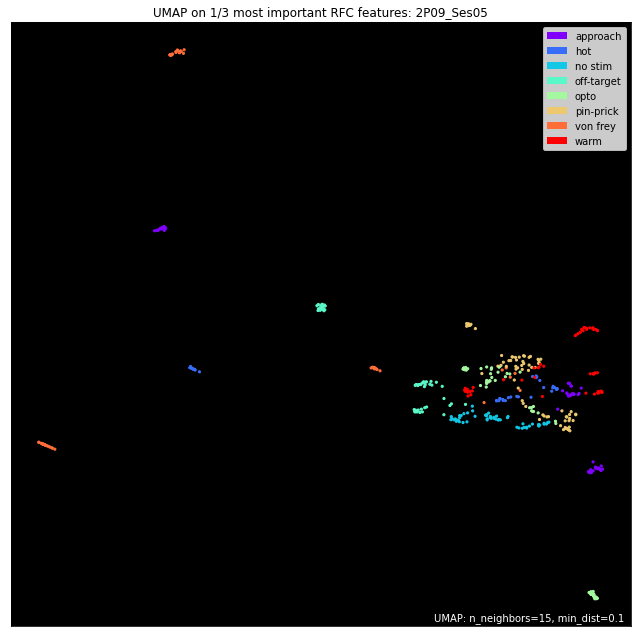

processing:  dF_F0_SHORT_2P10_Ses05.csv
2P10_Ses05
Accuracy modality: 0.9635036496350365


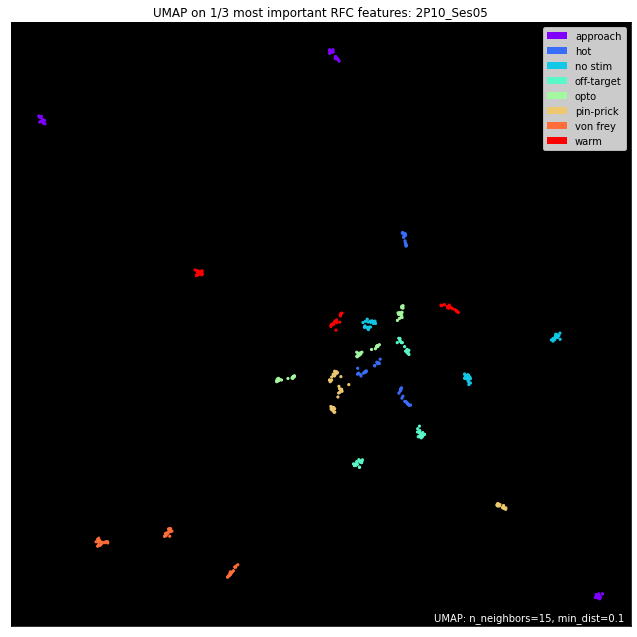

processing:  dF_F0_SHORT_2P11_Ses06.csv
2P11_Ses06
Accuracy modality: 0.9781021897810219


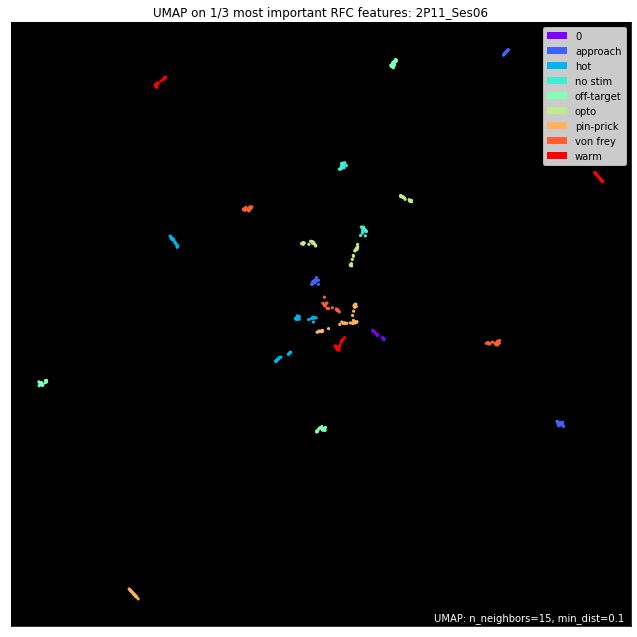

processing:  dF_F0_SHORT_2P11_CFA.csv
2P11_CFA
Accuracy modality: 0.9545454545454546


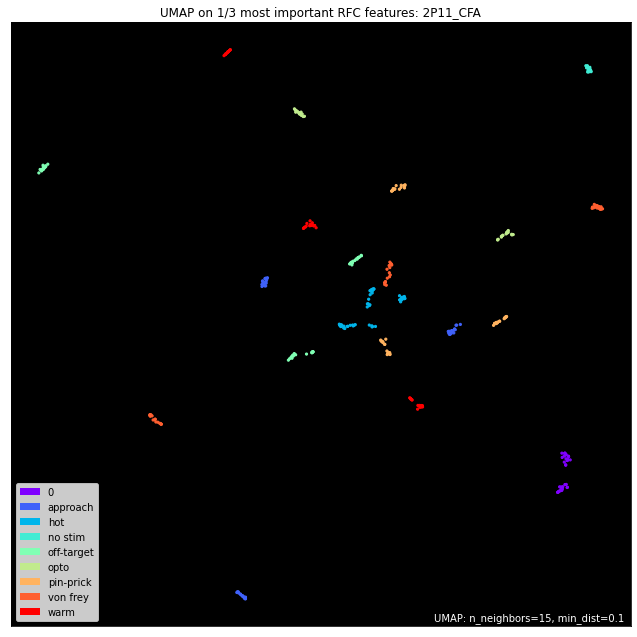

processing:  dF_F0_SHORT_2P05_Ses03.csv
2P05_Ses03
Accuracy modality: 0.9635036496350365


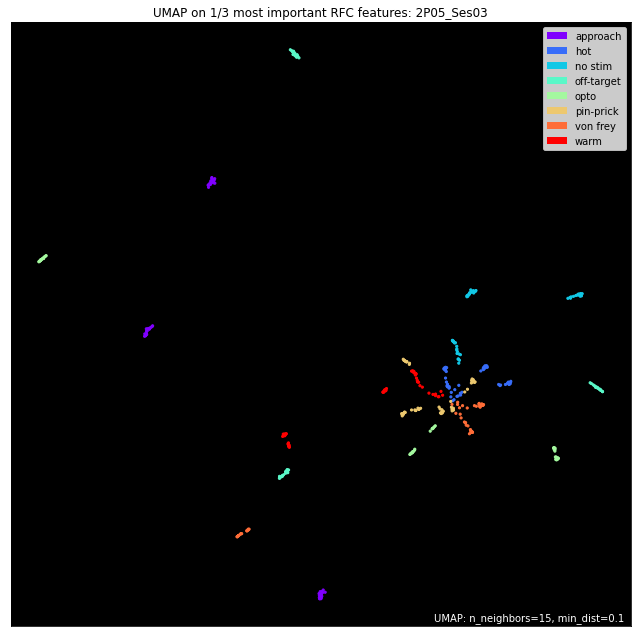

In [60]:
# PCA OR UMAP ON THE TOP 100 MOST IMPORTANT FEATURES
session_names = []
accuracies = []

for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Try a RFC on single session
    modality = np.array(cells['modality'])
    data = cells.drop(['identifier','modality'], axis=1)
    data = np.array(data)
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, modality, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality', metrics.accuracy_score(y_test, y_pred)])
    
    # Get importance of each feature
    feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
    feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
    #feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'.csv'))
    
    # Reduce data to the first third of feature importance and ran PCA on this subset
    third = int(len(feature_imp)/3)
    first_third_ids = feature_imp.iloc[:third].index.values.tolist()
    data = cells[cells.columns.intersection(first_third_ids)]
    data = np.array(data)
    std = StandardScaler()
    transformed = StandardScaler().fit_transform(data)

#     # Create a regular PCA model 
#     pca = PCA(n_components=2)

#     # Fit and transform the data to the model
#     reduced_data_pca = pca.fit_transform(transformed)

#     # Inspect the shape
#     reduced_data_pca.shape
    
#     colors = ['pink', 'magenta', 'blue', 'purple', 'lime', 'cyan', 'gray', 'black']
#     for i, stim in enumerate(stimuli):
#         x = reduced_data_pca[:, 0][modality == stim]
#         y = reduced_data_pca[:, 1][modality == stim]
#         plt.scatter(x, y, c=colors[i])
#     plt.legend(stimuli, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.xlabel('First Principal Component')
#     plt.ylabel('Second Principal Component')
#     plt.title("PCA on 1/3 most important features: "+ ses_name)
#     print(pca.explained_variance_)
#     print(pca.explained_variance_ratio_)
#     plt.savefig(os.path.join(output_path, 'pca_modalitites_'+ses_name), bbox_inches='tight')
#     plt.show()
    
#     # now use most import features with UMAP
#     mapper = umap.UMAP().fit(transformed)
#     umap.plot.points(mapper, labels=modality, theme='fire')
#     plt.title('UMAP on 1/3 most important RFC features: '+ ses_name)
#     plt.savefig(os.path.join(output_path, ses_name+'_umap_first_third.png'))
#     plt.show()



In [79]:
# Re-run RFC on top third important features only
session_names = []
accuracies = []

for session in [sessions[15]]:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Try a RFC on single session
    modality = np.array(cells['modality'])
    data = cells.drop(['identifier','modality'], axis=1)
    data = np.array(data)
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, modality, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality_full', metrics.accuracy_score(y_test, y_pred)])
    
    # Get importance of each feature
    feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
    feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
    #feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'.csv'))
    
    # Reduce data to the first third of feature importance and ran PCA on this subset
    third = int(len(feature_imp)/3)
    first_third_ids = feature_imp.iloc[:third].index.values.tolist()
    data = cells[cells.columns.intersection(first_third_ids)]
    data = np.array(data)
    
    # Run classifier again
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, modality, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality_top_third', metrics.accuracy_score(y_test, y_pred)])

# cols = ['session', 'classification', 'accuracy']
# rfc_accuracy_top_third = pd.DataFrame(accuracies, columns=cols)
# rfc_accuracy_top_third.to_csv(os.path.join(output_path, 'rfc_accuracies_top_third.csv'))

In [88]:
#important = forest.iloc[:100].index.values.tolist()
important = feature_imp.iloc[:third].index.values.tolist()
len(important)

185

In [90]:
ft = list(feature_imp.iloc[:third, :].index)
len(ft)

185

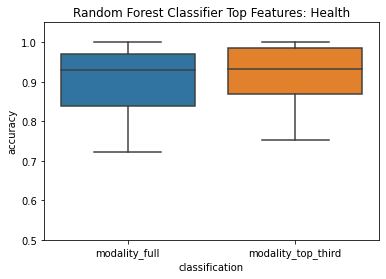

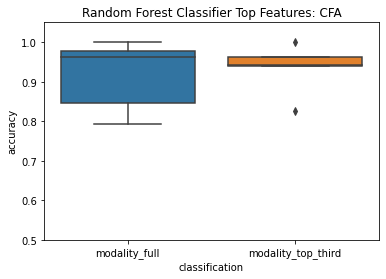

In [24]:
import seaborn as sns

health = rfc_accuracy_top_third[rfc_accuracy_top_third['session'].str.contains('Ses')]
cfa = rfc_accuracy_top_third[rfc_accuracy_top_third['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Random Forest Classifier Top Features: Health')
plt.ylim([0.5,1.05])
plt.savefig(os.path.join(output_path, 'rfc_top_third_health.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Random Forest Classifier Top Features: CFA')
plt.ylim([0.5,1.05])
plt.savefig(os.path.join(output_path, 'rfc_top_third_cfa.png'),bbox_inches='tight')
plt.show()

In [98]:
sessions = [session for session in os.listdir(output_path) if session.endswith('.csv')]
len(sessions)
mice = ['2P07', '2P08', '2P09', '2P10', '2P11']
last_session = ['2P07_Ses07','2P08_Ses06',  '2P09_Ses05', '2P10_Ses05', '2P11_Ses06']
session_names = []
accuracies = []

for mouse in [mice[2]]:
    
    index = [i for i, elem in enumerate(last_session) if mouse in elem][0]

    for session in sessions:
        if session.startswith('._'): # circumventing issues with invisible files on external drives
            continue
#         if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
#             continue
#         if session.endswith('2P05_Ses02.csv'):
#             continue
#         if session.endswith('2P07_Ses02.csv'):
#             continue
#         if session.endswith('2P11_Ses03.csv'):
#             continue
#         if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
#             continue
        if mouse in session:
            print('processing: ', session)
            entries = session.split('_')
    
            if session.endswith('CFA.csv'): 
                ses_name = entries[2]+'_'+entries[3][:3]
                cfa = pd.read_csv(os.path.join(output_path,session), index_col=0)
            elif session.endswith('01.csv'):
                ses_name = entries[2]+'_'+entries[3][:5]
                first = pd.read_csv(os.path.join(output_path,session),index_col=0)
            elif session.endswith(last_session[index]+'.csv'):
                ses_name = entries[2]+'_'+entries[3][:5]
                last = pd.read_csv(os.path.join(output_path,session),index_col=0)
            
#             else:
#                 continue
#             print(ses_name)
#             session_names.append(ses_name) 
        
#         else:
#             continue
            
        

processing:  feat_imp_2P09_Ses01.csv
processing:  feat_imp_2P09_Ses02.csv
processing:  feat_imp_2P09_Ses04.csv
processing:  feat_imp_2P09_CFA.csv
processing:  feat_imp_2P09_Ses03.csv
processing:  feat_imp_2P09_Ses05.csv


In [27]:
# Attempt to use entire session as training set and predict other sessions for single mouse
mice = ['2P07', '2P08', '2P09', '2P10', '2P11']
session_names = []
accuracies = []

for mouse in mice:
    length = 1000
    shortest = 'NA'
    for session in sessions:
        if session.startswith('._'): # circumventing issues with invisible files on external drives
            continue
        if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
            continue
        if session.endswith('2P05_Ses02.csv'):
            continue
        if session.endswith('2P07_Ses02.csv'):
            continue
        if session.endswith('2P11_Ses03.csv'):
            continue
        if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
            continue
            
        if mouse in session:
            
            print('processing: ', session)
            entries = session.split('_')
    
            if session.endswith('CFA.csv'): 
                ses_name = entries[3]+'_'+entries[4][:3]
        
            else:
                ses_name = entries[3]+'_'+entries[4][:5]
            

            cells = pd.read_csv(os.path.join(input_path,'dF_F0_SHORT_'+ses_name+'.csv'), index_col=0)
            l = cells.shape[0]
            print(ses_name, length)
            session_names.append(ses_name) 
            if l < length:
                length = l
                shortest = ses_name
                
            
        else:
            continue


    # assign shortest session as training set and keep only 150 most important cells
    cells = pd.read_csv(os.path.join(input_path,'dF_F0_SHORT_'+shortest+'.csv'), index_col=0)
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    importance = pd.read_csv(os.path.join(output_path, 'feat_imp_'+shortest+'.csv'), index_col=0)
    VIPs = importance.iloc[:150].index.values.tolist()
    data = cells[cells.columns.intersection(VIPs)]
    
    y_train = np.array(cells['modality'])
    X_train = np.array(data)
    
    clf = RandomForestClassifier(n_estimators=100)

    clf.fit(X_train, y_train)
    
    # iterate through remaining sessions and test model after cropping to the length of shortest session
    session_names.remove(shortest)
    for s in session_names:
        cells = pd.read_csv(os.path.join(input_path,'dF_F0_SHORT_'+s+'.csv'), index_col=0)
        cells = cells.iloc[:length,:]

        #Add 'modality' column
        conditions = [
        cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
        cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
        cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
        ]

        values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

        cells['modality'] = np.select(conditions, values)
        
        importance = pd.read_csv(os.path.join(output_path, 'feat_imp_'+s+'.csv'), index_col=0)
        VIPs = importance.iloc[:150].index.values.tolist()
        data = cells[cells.columns.intersection(VIPs)]
    
        y_test = np.array(cells['modality'])
        X_test = np.array(data)

        #Predict the response for test dataset
        y_pred = clf.predict(X_test)

        print("Accuracy for "+s+": ",metrics.accuracy_score(y_test, y_pred))
        accuracies.append([s, metrics.accuracy_score(y_test, y_pred)])
        
cols = ['session', 'accuracy']
rfc_accuracy_byMouse = pd.DataFrame(accuracies, columns=cols)
rfc_accuracy_byMouse.to_csv(os.path.join(output_path, 'rfc_accuracies_byMouse.csv'))

processing:  dF_F0_SHORT_2P05_Ses04.csv
2P05_Ses04 1000
processing:  dF_F0_SHORT_2P05_Ses06.csv
2P05_Ses06 456
processing:  dF_F0_SHORT_2P05_Ses07.csv
2P05_Ses07 456
processing:  dF_F0_SHORT_2P05_Ses03.csv
2P05_Ses03 418
Accuracy for 2P05_Ses04:  0.16028708133971292
Accuracy for 2P05_Ses06:  0.18421052631578946
Accuracy for 2P05_Ses03:  0.11004784688995216
processing:  dF_F0_SHORT_2P06_Ses01.csv
2P06_Ses01 1000
processing:  dF_F0_SHORT_2P06_Ses02.csv
2P06_Ses02 456
processing:  dF_F0_SHORT_2P06_Ses03.csv
2P06_Ses03 437
processing:  dF_F0_SHORT_2P06_Ses04.csv
2P06_Ses04 418
processing:  dF_F0_SHORT_2P06_Ses05.csv
2P06_Ses05 418
processing:  dF_F0_SHORT_2P06_Ses06.csv
2P06_Ses06 418
processing:  dF_F0_SHORT_2P06_Ses07.csv
2P06_Ses07 418
Accuracy for 2P05_Ses04:  0.11483253588516747
Accuracy for 2P05_Ses06:  0.10047846889952153
Accuracy for 2P05_Ses03:  0.07655502392344497
Accuracy for 2P06_Ses01:  0.11961722488038277
Accuracy for 2P06_Ses02:  0.11722488038277512
Accuracy for 2P06_Ses04: 

Accuracy for 2P10_Ses03:  0.18157894736842106
Accuracy for 2P10_Ses05:  0.20526315789473684
Accuracy for 2P11_Ses01:  0.2026315789473684
Accuracy for 2P11_Ses04:  0.08947368421052632
Accuracy for 2P11_Ses02:  0.1736842105263158
Accuracy for 2P11_Ses06:  0.12105263157894737
Accuracy for 2P11_CFA:  0.13157894736842105


In [28]:
rfc_accuracy_byMouse.head()

,session,accuracy
0,2P05_Ses04,0.160287
1,2P05_Ses06,0.184211
2,2P05_Ses03,0.110048
3,2P05_Ses04,0.114833
4,2P05_Ses06,0.100478


In [64]:
ref = ref_ses['ses_name']
ref

2    2P06_Ses03
Name: ses_name, dtype: object

In [ ]:
import seaborn as sns

health = rfc_accuracy_top_third[rfc_accuracy_top_third['session'].str.contains('Ses')]
cfa = rfc_accuracy_top_third[rfc_accuracy_top_third['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Random Forest Classifier Top Features: Health')
plt.ylim([0.5,1.05])
plt.savefig(os.path.join(output_path, 'rfc_top_third_health.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Random Forest Classifier Top Features: CFA')
plt.ylim([0.5,1.05])
plt.savefig(os.path.join(output_path, 'rfc_top_third_cfa.png'),bbox_inches='tight')
plt.show()